### Least squares equalizer for BPSK channel with additive Gaussian noise.

##### TO DO: allow for complex inputs (e.g., non-binary channels).

In [1]:
import numpy as np
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
"""Main function for generating metrics for the least squares equalizer.
   Params should include: {channel_length, snr, preamble_length}"""
def test(params={'channel_length':2, 'snr':1, 'preamble_length':100}, runs=1000):
    # extract parameters
    channel_length = params['channel_length']
    snr = params['snr']
    preamble_length = params['preamble_length']
    avg_bit_error = 0.
    for i in range(runs):
        # generate random channel
        channel = generate_random_channel(channel_length)
        # generate train data [the preamble]
        train_data = generate_data(preamble_length)
        received_train_data = apply_channel(channel, train_data, snr)
        # generate test data
        test_data = generate_data(int(1e3))
        received_test_data = apply_channel(channel, test_data, snr)
        # gradient descent
        h_E = learn_equalizer(channel_length, received_train_data, train_data)
        # recover message
        decoded = apply_channel(h_E, received_test_data)[:-2*(channel_length-1)]
        # test on output
        avg_bit_error += bit_errors(decoded, test_data)
    return avg_bit_error / (len(test_data)*runs)

In [90]:
"""Generate a channel with N taps."""
def generate_random_channel(n):
    return np.random.randn(n)

"""Generate data to send for the BPSK channel."""
def generate_data(n):
    return np.random.choice([-1, 1], n).astype(np.float64)

"""Add Gaussian noise with variance AMPLITUDE to SIGNAL."""
def add_noise(signal, amplitude): 
    signal[:] += np.sqrt(amplitude) * np.random.randn(len(signal))

In [80]:
"""Apply CHANNEL to CHANNEL_INPUT, with added Gaussian noise such that the
   signal to noise ration (SNR) is as input. 
   
   Set SNR to -1 for no noise."""
def apply_channel(channel, channel_input, snr=-1):
    out = sig.convolve(channel_input, channel, mode="full")
    # SNR: signal power is fixed at 1 in our model, so just scale the noise
    if snr > 0:
        add_noise(out, 1./snr)
    return out

In [83]:
"""Gradient descent on the squared error. 

   Channel length: H_LEN
   Received symbols: X
   Sent symbols: Y
   Iterate for: STEPS
   Learning rate: LR."""
def learn_equalizer(h_len, x, y, steps=1000, LR=1e-3):
    h = np.zeros(h_len)
    # discard the last h_len-1..these are leftover echoes
    x = np.roll(x, h_len-1)
    x[:h_len-1] = 0
    x_mat = np.zeros((len(y), h_len))
    for i in range(len(y)):
        x_mat[i,:] = np.flip(x[i:i+h_len], 0)
    # minimize error: np.linalg.norm(np.dot(x_mat, h) - y)**2
    while steps > 0:
        grad_update = np.dot(x_mat.T, np.dot(x_mat, h) - y)
        h = h - (LR / len(y))*grad_update
        steps -= 1
    return h

In [6]:
"""Calculate the number of bit errors between DECODED and SENT.
   Assumes binary channel (values sent are +1 or -1)."""
def bit_errors(decoded, sent):
    num_errors = 0
    for i in range(len(decoded)):
        if (decoded[i] >= 0 and sent[i] < 0) or (decoded[i] <= 0 and sent[i] > 0):
            num_errors += 1
    return num_errors

In [122]:
def plot_metric(metric_name, metric_range, semi_log=False, 
                base_params={'channel_length':2, 'snr':1, 'preamble_length':20}):
    np.random.seed(0)
    # copy to not overwrite default dictionary
    params = base_params.copy()
    plot_bit_errors = []
    for i in metric_range:
        params[metric_name] = i
        plot_bit_errors.append(test(params, runs=50))
    if semi_log:
        plt.semilogx(metric_range, plot_bit_errors)
    else:
        plt.plot(metric_range, plot_bit_errors)
    plt.title(metric_name.upper()+" vs Avg. # bit errors")
    plt.xlabel(metric_name.upper())
    plt.ylabel("Avg. # bit errors")
    plt.show()

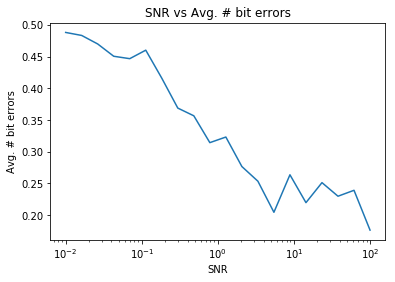

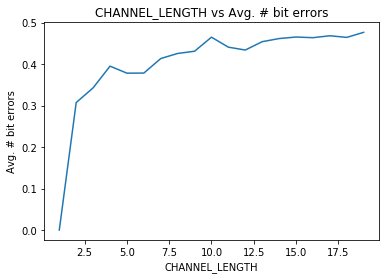

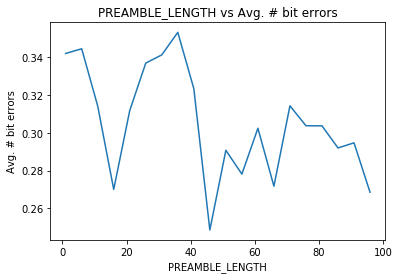

In [123]:
# plot metric: SNR
SNRs = np.logspace(-2., 2, 20)
plot_metric("snr", SNRs, semi_log=True)


# plot metric: channel length
channels = np.arange(1, 20, 1)
plot_metric("channel_length", channels)


# plot metric: preamble length
preambles = np.arange(1, 100, 5)
plot_metric("preamble_length", preambles)
